In [38]:
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
import pandas as pd
from scipy.signal import savgol_filter
import sklearn.linear_model as lm
from sklearn.preprocessing import PolynomialFeatures
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks, detrend
from lmfit import Parameters, Model
from lmfit.models import LorentzianModel, VoigtModel, GaussianModel
from scipy.ndimage.filters import uniform_filter1d

C:\Users\James\AppData\Local\Temp\ipykernel_15548\2492558538.py:12: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [39]:
# read data and extract
file = r"C:\Users\James\OneDrive - Nexus365\DPhil-general\Experiments\SIBC StrucMag\Pristine Raman Data\Pristine raw _ new (lower power)\5 Fu21Gd-SM-avg-532nm.txt"
header = 12
skiprows=100
data = pd.read_table(file, delimiter = '\t', header = header, skiprows = skiprows)
data.columns = ['Wavenumber', 'Intensity']

# normalise intensity
# data['Intensity'] = np.interp(data['Intensity'], (data['Intensity'].min(), data['Intensity'].max()), (0, 1))


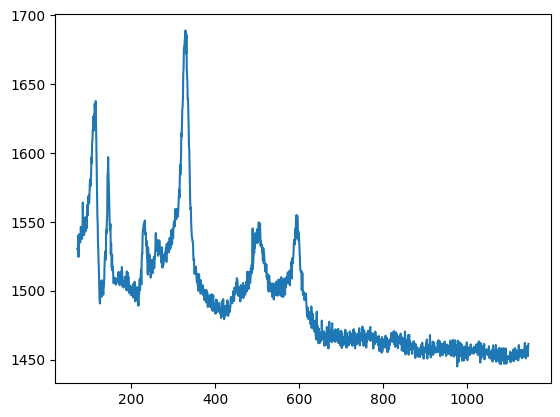

In [40]:
wavenumber, intensity = data['Wavenumber'], data['Intensity']

plt.plot(wavenumber, intensity, label = 'Fu21Gd')

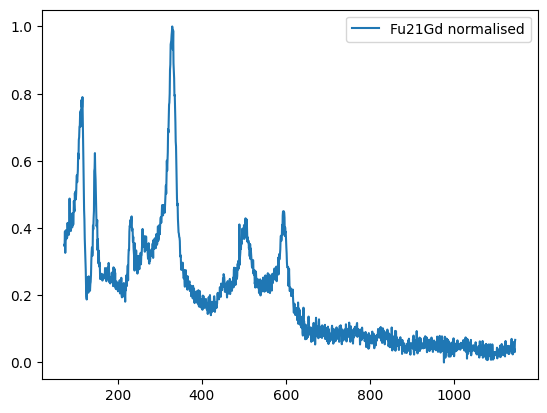

In [41]:
# normalise
intensity = np.interp(intensity, (intensity.min(), intensity.max()), (0, 1))
plt.plot(wavenumber, intensity, label = 'Fu21Gd normalised')
plt.legend()

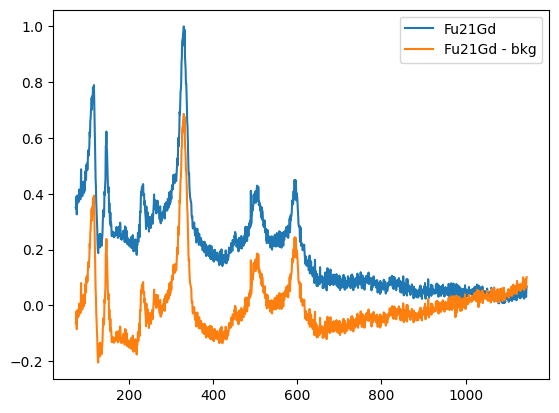

In [42]:
"""try subtracting background via linear detrending"""
data = [wavenumber, intensity]
data = np.array(data)
bkg_sub = detrend(data, type='linear')


plt.plot(wavenumber, intensity, label = 'Fu21Gd')

plt.plot(wavenumber, bkg_sub[1], label = 'Fu21Gd - bkg')
plt.legend()

'seems a bit wack'

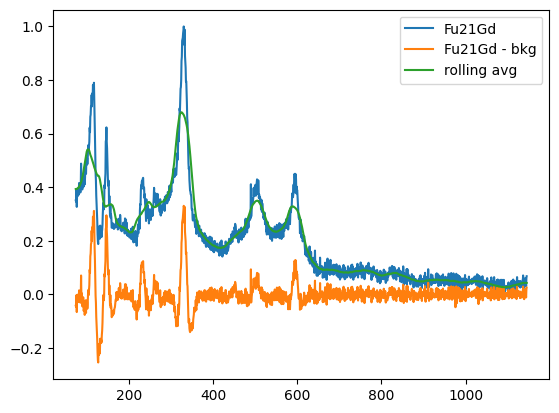

In [43]:
"""try background subtraction with rolling average"""
window = 50
rolling_avg = uniform_filter1d(intensity, size=window)
bkg_sub = intensity - rolling_avg

plt.plot(wavenumber, intensity, label = 'Fu21Gd')
plt.plot(wavenumber, bkg_sub, label = 'Fu21Gd - bkg')
plt.plot(wavenumber, rolling_avg, label = 'rolling avg')
plt.legend()

"""seems a bit wack"""

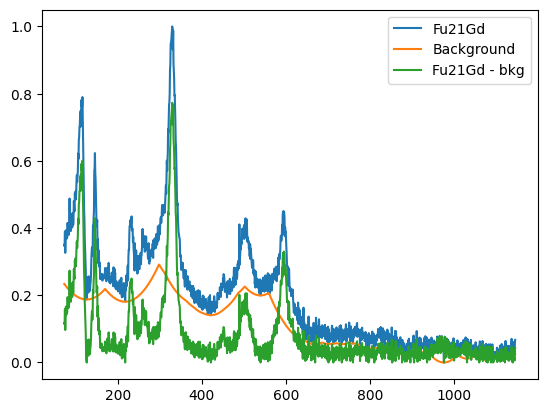

In [44]:
""" scikit image rolling ball background subtraction"""
from skimage import restoration

bkg = restoration.rolling_ball(intensity, radius=50000)
subtracted = intensity - bkg

plt.plot(wavenumber, intensity, label = 'Fu21Gd')
plt.plot(wavenumber, bkg, label = 'Background')
plt.plot(wavenumber, subtracted, label = 'Fu21Gd - bkg')

plt.legend()

[0.54766568 0.32834516 0.22641303 0.14734247 0.730078   0.08413725
 0.17711303 0.30613566 0.05559435]
52      113.620
93      145.656
204     231.473
242     260.551
333     329.574
496     451.114
569     504.700
693     594.564
1227    965.929
Name: Wavenumber, dtype: float64


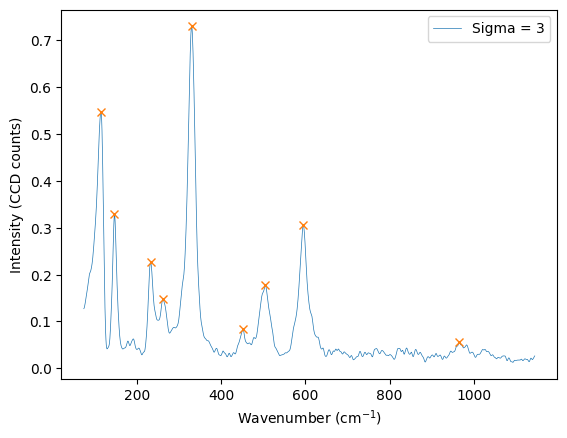

In [56]:
# gaussian smoothing
sigma = 3
smoothed_intensity = gaussian_filter(subtracted, sigma=sigma)
plt.plot(wavenumber, smoothed_intensity, label = 'Sigma = {}'.format(sigma), linewidth = 0.5)
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (CCD counts)')
plt.legend()

# peaks find for gaussian smoothed
prominence = 0.03
peaks_ix, _ = find_peaks(smoothed_intensity, prominence=prominence)
peaks_x, peaks_y = wavenumber[peaks_ix], smoothed_intensity[peaks_ix]
plt.plot(peaks_x, peaks_y, "x")
print(peaks_y)
print(peaks_x)

In [46]:
roughpeaks = peaks_ix[:].tolist()
print('Rough peak locations are: \n', roughpeaks, '\n Are you satisfied with these peaks?')

Rough peak locations are: 
 [52, 93, 204, 242, 333, 496, 569, 693, 1227] 
 Are you satisfied with these peaks?


In [47]:
"""Fit individual peaks extracted from rough peaks"""
# select individual peak by roughpeak value
window = 30
peak_no = 2
intensity_peak = smoothed_intensity[roughpeaks[peak_no]-window:roughpeaks[peak_no]+window]
wavenumber_peak = wavenumber[roughpeaks[peak_no]-window:roughpeaks[peak_no]+window]

# converting to dataframe
intensity_df, wavenumber_df = pd.DataFrame(intensity_peak, columns=['Intensity']), pd.DataFrame(wavenumber_peak, columns=['Wavenumber'])
intensity_df, wavenumber_df = intensity_df.reset_index(), wavenumber_df.reset_index()




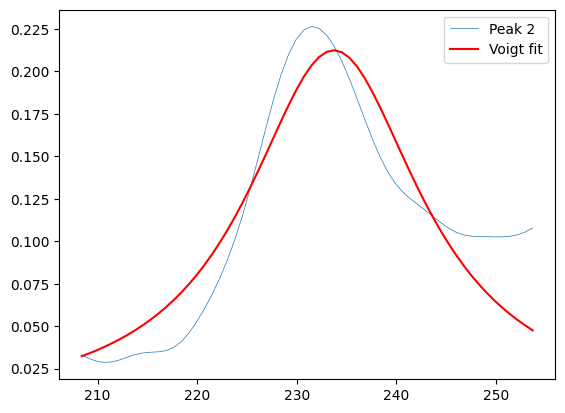

[[Model]]
    Model(voigt)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 60
    # variables        = 4
    chi-square         = 0.03545036
    reduced chi-square = 6.3304e-04
    Akaike info crit   = -438.037986
    Bayesian info crit = -429.660608
    R-squared          = 0.84664945
[[Variables]]
    amplitude:  7.15213356 +/- 0.31780139 (4.44%) (init = 6.826853)
    center:     233.716071 +/- 0.39440216 (0.17%) (init = 233.0052)
    sigma:      2.4062e-05 +/- 42225.9475 (175490809260.60%) (init = 4.9855)
    gamma:      10.7176077 +/- 0.69547371 (6.49%) (init = 0.7)
    fwhm:       21.4352808 +/- 1.39095166 (6.49%) == '1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'
    height:     0.21241632 +/- 1.63193200 (768.27%) == '(amplitude/(max(1e-15, sigma*sqrt(2*pi))))*real(wofz((1j*gamma)/(max(1e-15, sigma*sqrt(2)))))'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, gamma) = +0.8144
    C(sigma, gamma

In [48]:
"""# fitting individual peak...  """

mod = VoigtModel()
pars = mod.guess(intensity_df['Intensity'], x=wavenumber_df['Wavenumber'])
pars['gamma'].set(value=0.7, vary=True, expr='')
out = mod.fit(intensity_df['Intensity'], pars, x=wavenumber_df['Wavenumber'])

plt.plot(wavenumber_peak, intensity_peak, label = 'Peak {}'.format(peak_no), linewidth = 0.5)
plt.plot(wavenumber_df['Wavenumber'], out.best_fit, 'r-', label='Voigt fit')
plt.legend()
plt.show()

print(out.fit_report(min_correl=0.25))


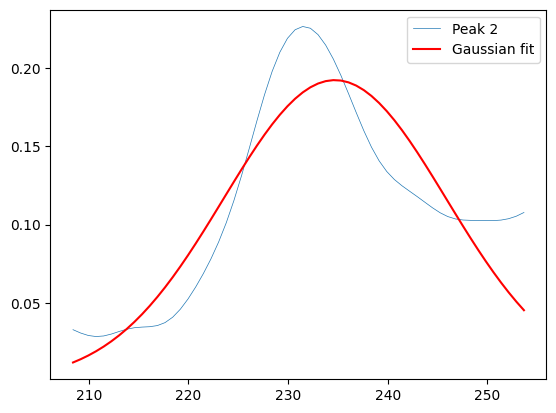

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 60
    # variables        = 3
    chi-square         = 0.04348571
    reduced chi-square = 7.6291e-04
    Akaike info crit   = -427.780047
    Bayesian info crit = -421.497013
    R-squared          = 0.81189027
[[Variables]]
    amplitude:  5.38310145 +/- 0.19950688 (3.71%) (init = 4.551235)
    center:     234.697117 +/- 0.46334040 (0.20%) (init = 233.0052)
    sigma:      11.1731763 +/- 0.50432571 (4.51%) (init = 7.67)
    fwhm:       26.3108190 +/- 1.18759626 (4.51%) == '2.3548200*sigma'
    height:     0.19220558 +/- 0.00682250 (3.55%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma) = +0.6429


In [49]:
"""# fitting individual peak... with gaussian model"""

mod = GaussianModel()

pars = mod.guess(intensity_df['Intensity'], x=wavenumber_df['Wavenumber'])
out = mod.fit(intensity_df['Intensity'], pars, x=wavenumber_df['Wavenumber'])

plt.plot(wavenumber_peak, intensity_peak, label = 'Peak {}'.format(peak_no), linewidth = 0.5)
plt.plot(wavenumber_df['Wavenumber'], out.best_fit, 'r-', label='Gaussian fit')
plt.legend()
plt.show()

print(out.fit_report(min_correl=0.25))

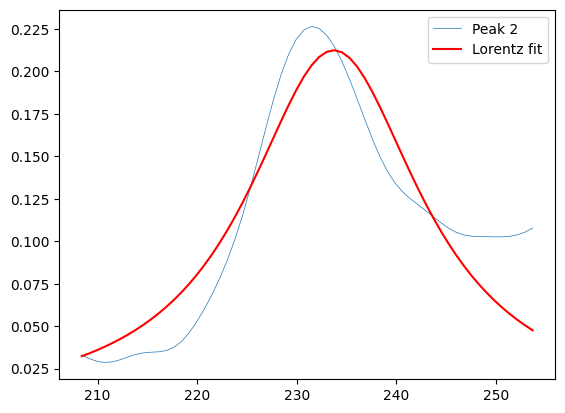

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 60
    # variables        = 3
    chi-square         = 0.03545036
    reduced chi-square = 6.2194e-04
    Akaike info crit   = -440.037986
    Bayesian info crit = -433.754952
    R-squared          = 0.84664945
[[Variables]]
    amplitude:  7.15207555 +/- 0.28972548 (4.05%) (init = 5.689044)
    center:     233.715993 +/- 0.38556507 (0.16%) (init = 233.0052)
    sigma:      10.7174498 +/- 0.61624625 (5.75%) (init = 7.67)
    fwhm:       21.4348997 +/- 1.23249250 (5.75%) == '2.0000000*sigma'
    height:     0.21241774 +/- 0.00774473 (3.65%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma) = +0.7766


In [50]:
""" fitting individual peak with lorentzian model"""
mod = LorentzianModel()

pars = mod.guess(intensity_df['Intensity'], x=wavenumber_df['Wavenumber'])
out = mod.fit(intensity_df['Intensity'], pars, x=wavenumber_df['Wavenumber'])


plt.plot(wavenumber_peak, intensity_peak, label = 'Peak {}'.format(peak_no), linewidth = 0.5)
plt.plot(wavenumber_df['Wavenumber'], out.best_fit, 'r-', label='Lorentz fit')
plt.legend()
plt.show()

print(out.fit_report(min_correl=0.25))

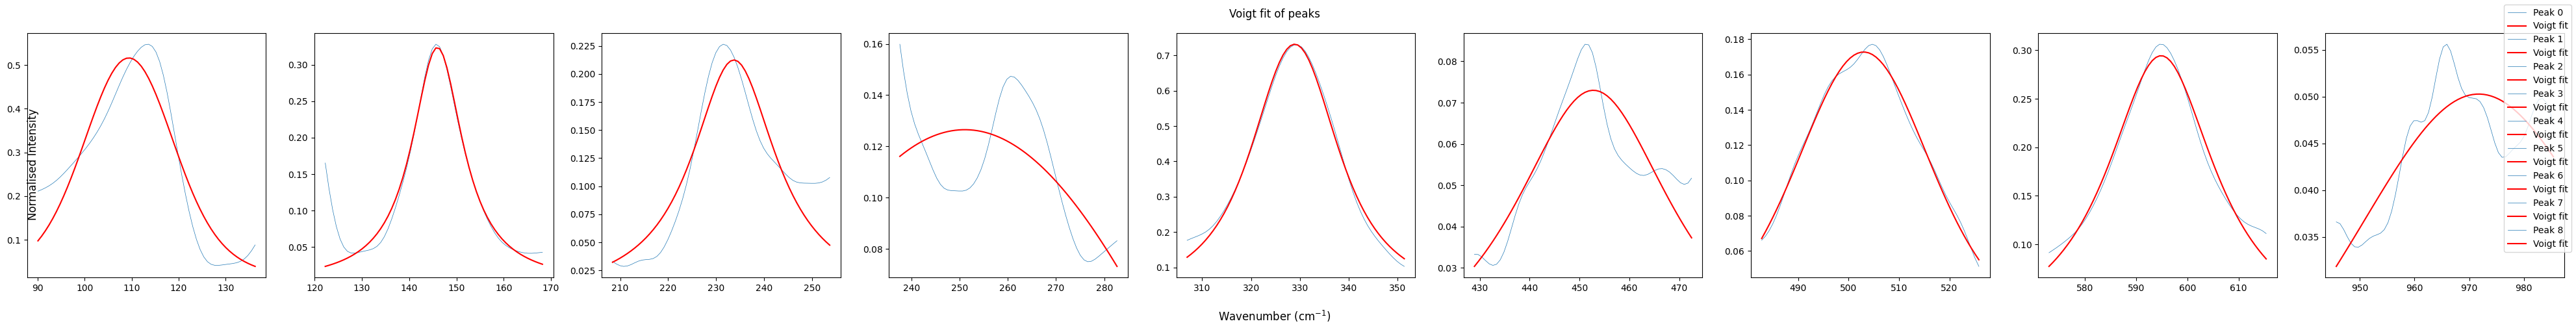

In [51]:
""" fitting all peaks in one go"""

window = 30
fig, axs = plt.subplots(nrows=1, ncols=len(roughpeaks), figsize=(40,5))

for i in range(len(roughpeaks)):

    peak_no = i
    intensity_peak = smoothed_intensity[roughpeaks[peak_no]-window:roughpeaks[peak_no]+window]
    wavenumber_peak = wavenumber[roughpeaks[peak_no]-window:roughpeaks[peak_no]+window]

    # converting to dataframe
    intensity_df, wavenumber_df = pd.DataFrame(intensity_peak, columns=['Intensity']), pd.DataFrame(wavenumber_peak, columns=['Wavenumber'])
    intensity_df, wavenumber_df = intensity_df.reset_index(), wavenumber_df.reset_index()

    mod = VoigtModel()
    pars = mod.guess(intensity_df['Intensity'], x=wavenumber_df['Wavenumber'])
    pars['gamma'].set(value=0.7, vary=True, expr='')
    out = mod.fit(intensity_df['Intensity'], pars, x=wavenumber_df['Wavenumber'])

    axs[i].plot(wavenumber_peak, intensity_peak, label = 'Peak {}'.format(peak_no), linewidth = 0.5)
    axs[i].plot(wavenumber_df['Wavenumber'], out.best_fit, 'r-', label='Voigt fit')

# plt.legend()
fig.supylabel('Normalised Intensity')
fig.supxlabel('Wavenumber (cm$^{-1}$)')
fig.suptitle('Voigt fit of peaks')
fig.legend()
plt.tight_layout()
plt.show()

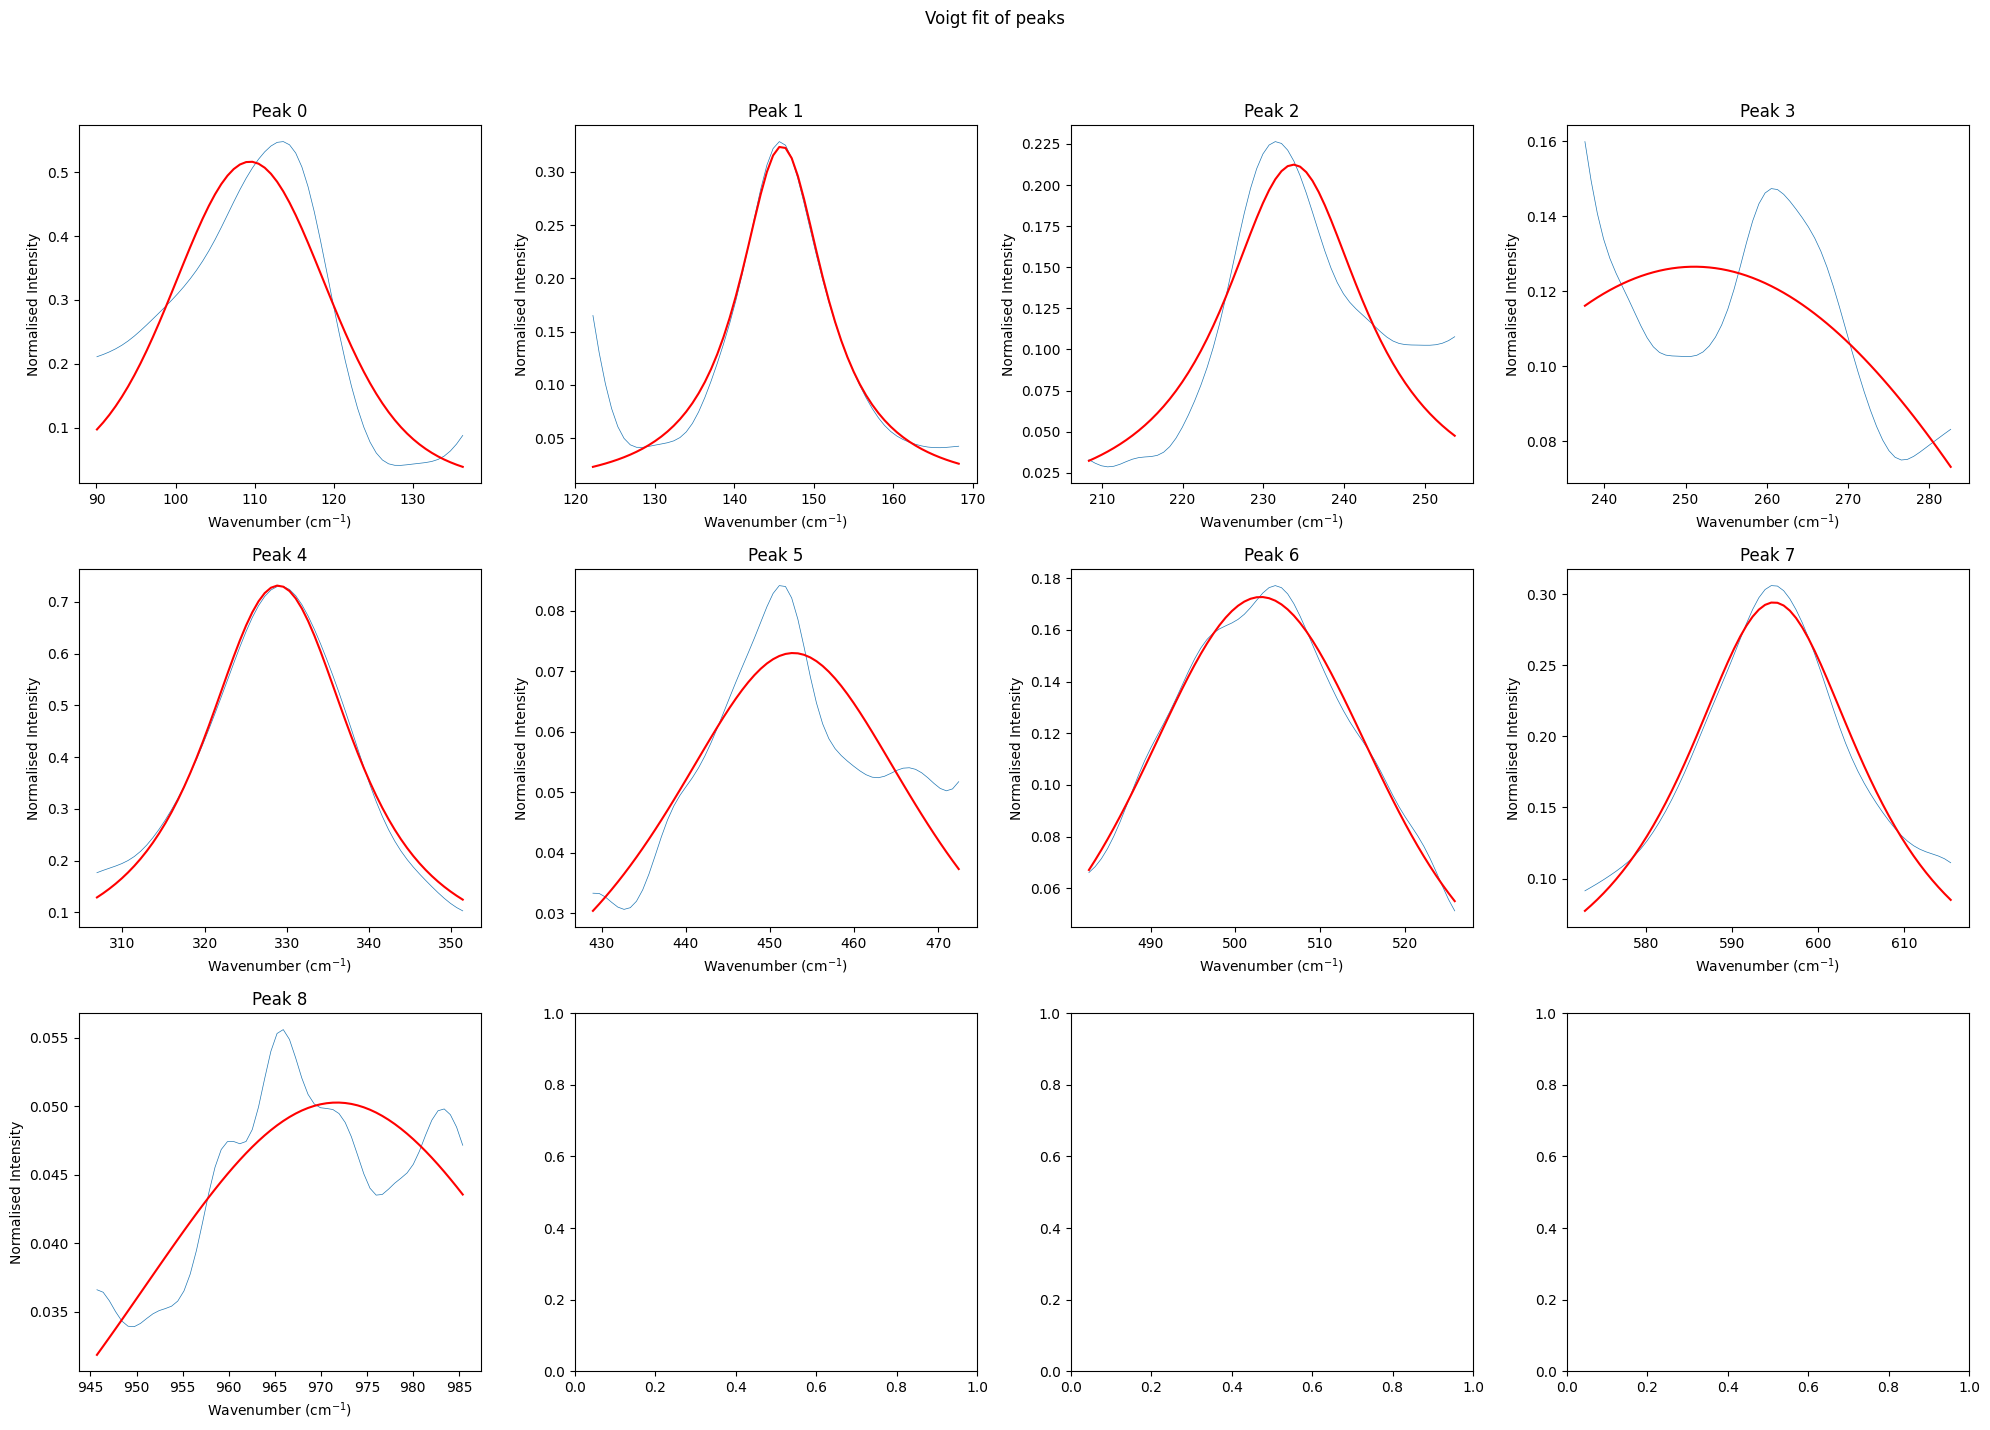

In [52]:
window = 30
num_peaks = len(roughpeaks)
num_cols = min(num_peaks, 4)  # Set maximum of 4 columns
num_rows = int(np.ceil(num_peaks / num_cols))

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5*num_rows))

for i in range(num_peaks):

    peak_no = i
    intensity_peak = smoothed_intensity[roughpeaks[peak_no]-window:roughpeaks[peak_no]+window]
    wavenumber_peak = wavenumber[roughpeaks[peak_no]-window:roughpeaks[peak_no]+window]

    # converting to dataframe
    intensity_df, wavenumber_df = pd.DataFrame(intensity_peak, columns=['Intensity']), pd.DataFrame(wavenumber_peak, columns=['Wavenumber'])
    intensity_df, wavenumber_df = intensity_df.reset_index(), wavenumber_df.reset_index()

    mod = VoigtModel()
    pars = mod.guess(intensity_df['Intensity'], x=wavenumber_df['Wavenumber'])
    pars['gamma'].set(value=0.7, vary=True, expr='')
    out = mod.fit(intensity_df['Intensity'], pars, x=wavenumber_df['Wavenumber'])

    row_idx = i // num_cols
    col_idx = i % num_cols
    if num_rows == 1:
        axs[col_idx].plot(wavenumber_peak, intensity_peak, label='Peak {}'.format(peak_no), linewidth=0.5)
        axs[col_idx].plot(wavenumber_df['Wavenumber'], out.best_fit, 'r-', label='Voigt fit')
        axs[col_idx].set_ylabel('Normalised Intensity')
        axs[col_idx].set_xlabel('Wavenumber (cm$^{-1}$)')
        axs[col_idx].set_title('Peak {}'.format(peak_no))
    else:
        axs[row_idx, col_idx].plot(wavenumber_peak, intensity_peak, label='Peak {}'.format(peak_no), linewidth=0.5)
        axs[row_idx, col_idx].plot(wavenumber_df['Wavenumber'], out.best_fit, 'r-', label='Voigt fit')
        axs[row_idx, col_idx].set_ylabel('Normalised Intensity')
        axs[row_idx, col_idx].set_xlabel('Wavenumber (cm$^{-1}$)')
        axs[row_idx, col_idx].set_title('Peak {}'.format(peak_no))

plt.suptitle('Voigt fit of peaks')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [53]:
# """ try fitting all peaks in one go on whole dataset"""


# # Define individual Voigt models
# voigt_models = [VoigtModel(prefix='voigt{}_'.format(i)) for i in range(len(roughpeaks))]

# print(voigt_models)
# # Combine individual models into a composite model
# # composite_model = Model(voigt_models[i] + voigt_models[i+1] for i in range(len(voigt_models)-1))
# expression = '+'.join(['voigt{}_'.format(i) for i in range(len(roughpeaks))])
# print(expression)
# composite_model = Model(expression)
# print(composite_model)

# # Set initial guesses for parameters
# params = Parameters()
# for i, voigt_model in enumerate(voigt_models):
#     params += voigt_model.make_params(amplitude=1, center=roughpeaks[i], sigma=1, gamma=1)

# # Perform the fit
# result = composite_model.fit(smoothed_intensity, params, x=wavenumber)

In [60]:
""" fitting mutliple voigt models"""

# composite_model = [VoigtModel(prefix='voigt{}_'.format(i)) for i in range(len(roughpeaks))]
# expression = ' + '.join(Model[('voigt{}_'.format(i)) for i in range(len(roughpeaks))])

# Set initial guesses for parameters
# params = Parameters()
# for i, voigt_model in enumerate(composite_model):
#     params += voigt_model.make_params(amplitude=1, center=roughpeaks[i], sigma=1, gamma=1)

# # Create multiple voigt models
# voigt0 = VoigtModel(prefix='voigt0_')
# voigt1 = VoigtModel(prefix='voigt1_')
# voigt2 = VoigtModel(prefix='voigt2_')
# voigt3 = VoigtModel(prefix='voigt3_')
# voigt4 = VoigtModel(prefix='voigt4_')
# voigt5 = VoigtModel(prefix='voigt5_')
# voigt6 = VoigtModel(prefix='voigt6_')
# voigt7 = VoigtModel(prefix='voigt7_')
# voigt8 = VoigtModel(prefix='voigt8_')


# # Combine individual models into a composite model
# composite_model = voigt0 + voigt1 + voigt2 + voigt3

# # Set initial guesses for parameters
# params = voigt0.make_params(amplitude=peaks_y[0], center=roughpeaks[0], sigma=1, gamma=1)
# params += voigt1.make_params(amplitude=peaks_y[1], center=roughpeaks[1], sigma=1, gamma=1)
# params += voigt2.make_params(amplitude=peaks_y[2], center=roughpeaks[2], sigma=1, gamma=1)
# params += voigt3.make_params(amplitude=peaks_y[3], center=roughpeaks[3], sigma=1, gamma=1)
# params += voigt4.make_params(amplitude=peaks_y[4], center=roughpeaks[4], sigma=1, gamma=1)
# params += voigt5.make_params(amplitude=peaks_y[5], center=roughpeaks[5], sigma=1, gamma=1)
# params += voigt6.make_params(amplitude=peaks_y[6], center=roughpeaks[6], sigma=1, gamma=1)
# params += voigt7.make_params(amplitude=peaks_y[7], center=roughpeaks[7], sigma=1, gamma=1)
# params += voigt8.make_params(amplitude=peaks_y[8], center=roughpeaks[8], sigma=1, gamma=1)

from lmfit import Model

# Define individual Voigt models dynamically based on the length of roughpeaks
voigt_models = []
for i in range(len(roughpeaks)):
    voigt_models.append(VoigtModel(prefix='voigt{}_'.format(i), independent_vars=['x']))

# Define the composite model as the sum of all individual Voigt models
composite_model = Model(voigt_models[0])
for voigt_model in voigt_models[1:]:
    composite_model += voigt_model

# Set initial guesses for parameters
params = composite_model.make_params()
for i, voigt_model in enumerate(voigt_models):
    params.update(voigt_model.make_params(amplitude=peaks_y[i], center=roughpeaks[i], sigma=1, gamma=1))


# Perform the fit
result = composite_model.fit(smoothed_intensity, params, x=wavenumber)


plt.plot(wavenumber, smoothed_intensity, label = 'Fu21Gd')
plt.plot(wavenumber, result.best_fit, 'r-', label='Voigt fit')
plt.legend()
plt.show()



TypeError: Model(voigt, prefix='voigt0_') is not a callable object